In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 2

In [3]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 1])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, input_shape=(timesteps, features)))
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(1, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    #inp= np.append(inp[0],[[yhat[0][0],yhat[0][1]]],axis=0) #adiciona previsão recente ao input
    #inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  print(forecasts)
  return forecasts

In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

                }
# record da history de cada modelo
record = {}

Epoch 1/10
51/51 [==============================] - 3s 21ms/step - loss: 0.2677 - mae: 0.2651 - rmse: 0.2677 - val_loss: 0.0199 - val_mae: 0.0185 - val_rmse: 0.0192
Epoch 2/10
51/51 [==============================] - 0s 5ms/step - loss: 0.1159 - mae: 0.1120 - rmse: 0.1159 - val_loss: 0.0293 - val_mae: 0.0284 - val_rmse: 0.0287
Epoch 3/10
51/51 [==============================] - 0s 6ms/step - loss: 0.1540 - mae: 0.1510 - rmse: 0.1540 - val_loss: 0.0771 - val_mae: 0.0767 - val_rmse: 0.0777
Epoch 4/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0843 - mae: 0.0795 - rmse: 0.0843 - val_loss: 0.0816 - val_mae: 0.0812 - val_rmse: 0.0822
Epoch 5/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0836 - mae: 0.0787 - rmse: 0.0836 - val_loss: 0.0791 - val_mae: 0.0787 - val_rmse: 0.0797

Epoch 00005: val_loss improved from inf to 0.07911, saving model to my_model_5_0.079.h5
Epoch 6/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0853 - mae: 0.08

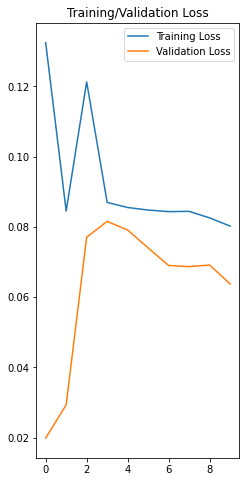

Epoch 1/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0655 - mae: 0.0625 - rmse: 0.0655 - val_loss: 0.0216 - val_mae: 0.0188 - val_rmse: 0.0210
Epoch 2/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0885 - mae: 0.0858 - rmse: 0.0881 - val_loss: 0.0229 - val_mae: 0.0203 - val_rmse: 0.0228
Epoch 3/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0710 - mae: 0.0685 - rmse: 0.0708 - val_loss: 0.0247 - val_mae: 0.0222 - val_rmse: 0.0247
Epoch 4/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0675 - mae: 0.0648 - rmse: 0.0673 - val_loss: 0.0253 - val_mae: 0.0229 - val_rmse: 0.0253
Epoch 5/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0665 - mae: 0.0637 - rmse: 0.0662 - val_loss: 0.0236 - val_mae: 0.0211 - val_rmse: 0.0235

Epoch 00005: val_loss improved from 0.06376 to 0.02360, saving model to my_model_5_0.024.h5
Epoch 6/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0

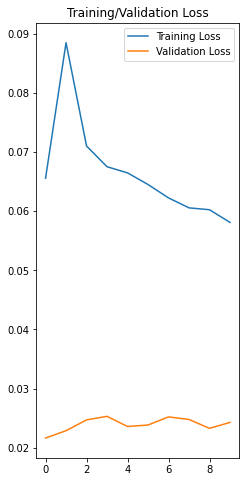

Epoch 1/10
152/152 [==============================] - 2s 5ms/step - loss: 0.0458 - mae: 0.0430 - rmse: 0.0458 - val_loss: 0.0576 - val_mae: 0.0488 - val_rmse: 0.0583
Epoch 2/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0363 - mae: 0.0332 - rmse: 0.0363 - val_loss: 0.0568 - val_mae: 0.0468 - val_rmse: 0.0574
Epoch 3/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0269 - mae: 0.0238 - rmse: 0.0269 - val_loss: 0.0523 - val_mae: 0.0424 - val_rmse: 0.0532
Epoch 4/10
152/152 [==============================] - 1s 5ms/step - loss: 0.0319 - mae: 0.0286 - rmse: 0.0319 - val_loss: 0.0568 - val_mae: 0.0465 - val_rmse: 0.0573
Epoch 5/10
152/152 [==============================] - 1s 5ms/step - loss: 0.0276 - mae: 0.0245 - rmse: 0.0276 - val_loss: 0.0526 - val_mae: 0.0428 - val_rmse: 0.0533

Epoch 00005: val_loss did not improve from 0.02360
Epoch 6/10
152/152 [==============================] - 1s 5ms/step - loss: 0.0357 - mae: 0.0324 - rmse: 0.0357 - val_lo

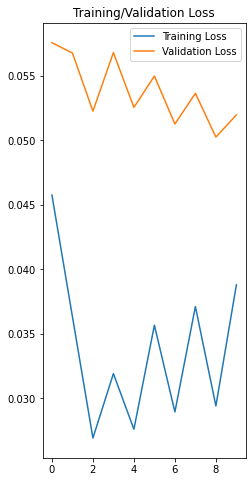

[array([[2471.3555]], dtype=float32)]
[array([[2471.3555]], dtype=float32)]
[2471.3555]


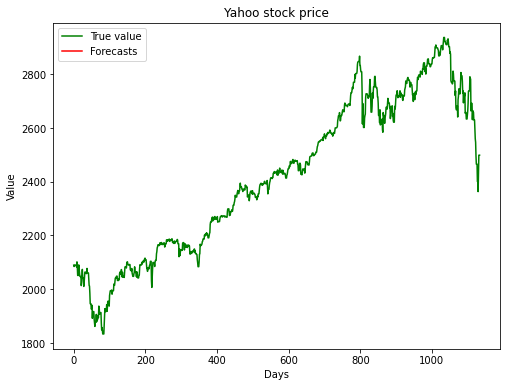

Epoch 1/50
51/51 [==============================] - 2s 16ms/step - loss: 0.2134 - mae: 0.2103 - rmse: 0.2133 - val_loss: 0.0144 - val_mae: 0.0126 - val_rmse: 0.0138
Epoch 2/50
51/51 [==============================] - 0s 6ms/step - loss: 0.1013 - mae: 0.0970 - rmse: 0.1013 - val_loss: 0.0317 - val_mae: 0.0308 - val_rmse: 0.0310
Epoch 3/50
51/51 [==============================] - 0s 6ms/step - loss: 0.1213 - mae: 0.1181 - rmse: 0.1212 - val_loss: 0.0228 - val_mae: 0.0211 - val_rmse: 0.0233
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 0.1245 - mae: 0.1206 - rmse: 0.1245 - val_loss: 0.0797 - val_mae: 0.0793 - val_rmse: 0.0803
Epoch 5/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0846 - mae: 0.0797 - rmse: 0.0846 - val_loss: 0.0794 - val_mae: 0.0790 - val_rmse: 0.0799

Epoch 00005: val_loss improved from inf to 0.07936, saving model to my_model_5_0.079.h5
Epoch 6/50
51/51 [==============================] - 0s 7ms/step - loss: 0.0838 - mae: 0.07

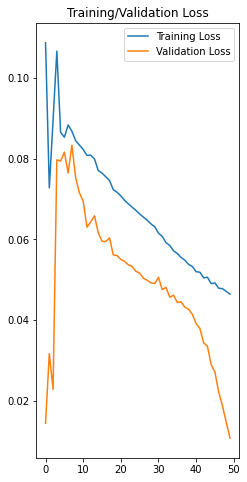

Epoch 1/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0353 - mae: 0.0319 - rmse: 0.0351 - val_loss: 0.0351 - val_mae: 0.0335 - val_rmse: 0.0346
Epoch 2/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0377 - mae: 0.0345 - rmse: 0.0375 - val_loss: 0.0427 - val_mae: 0.0412 - val_rmse: 0.0428
Epoch 3/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0540 - mae: 0.0513 - rmse: 0.0538 - val_loss: 0.0225 - val_mae: 0.0205 - val_rmse: 0.0223
Epoch 4/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0561 - mae: 0.0533 - rmse: 0.0560 - val_loss: 0.0229 - val_mae: 0.0209 - val_rmse: 0.0226
Epoch 5/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0514 - mae: 0.0483 - rmse: 0.0512 - val_loss: 0.0356 - val_mae: 0.0339 - val_rmse: 0.0353

Epoch 00005: val_loss did not improve from 0.01077
Epoch 6/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0488 - mae: 0.0457 - rmse: 0.0487 - val_lo

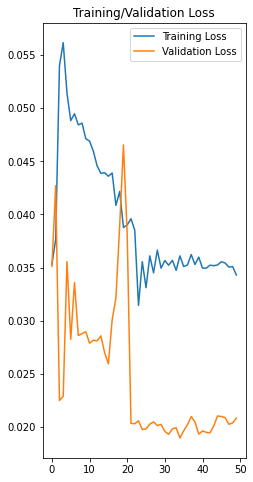

Epoch 1/50
152/152 [==============================] - 2s 5ms/step - loss: 0.0294 - mae: 0.0258 - rmse: 0.0294 - val_loss: 0.0520 - val_mae: 0.0452 - val_rmse: 0.0523
Epoch 2/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0258 - mae: 0.0216 - rmse: 0.0258 - val_loss: 0.0490 - val_mae: 0.0431 - val_rmse: 0.0492
Epoch 3/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0201 - mae: 0.0158 - rmse: 0.0201 - val_loss: 0.0505 - val_mae: 0.0443 - val_rmse: 0.0508
Epoch 4/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0207 - mae: 0.0163 - rmse: 0.0207 - val_loss: 0.0514 - val_mae: 0.0453 - val_rmse: 0.0517
Epoch 5/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0210 - mae: 0.0166 - rmse: 0.0210 - val_loss: 0.0525 - val_mae: 0.0463 - val_rmse: 0.0527

Epoch 00005: val_loss did not improve from 0.01077
Epoch 6/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0213 - mae: 0.0170 - rmse: 0.0213 - val_lo

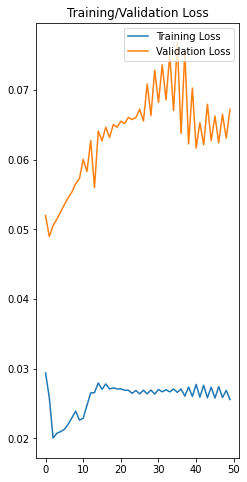

[array([[2493.417]], dtype=float32)]
[array([[2493.417]], dtype=float32)]
[2493.417]


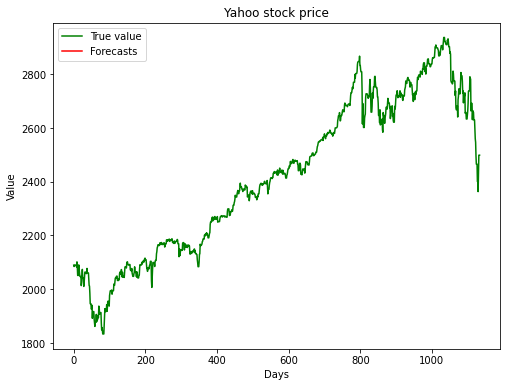

Epoch 1/100
51/51 [==============================] - 2s 15ms/step - loss: 0.2384 - mae: 0.2351 - rmse: 0.2384 - val_loss: 0.0241 - val_mae: 0.0230 - val_rmse: 0.0235
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.1018 - mae: 0.0976 - rmse: 0.1018 - val_loss: 0.0212 - val_mae: 0.0199 - val_rmse: 0.0206
Epoch 3/100
51/51 [==============================] - 0s 6ms/step - loss: 0.1132 - mae: 0.1093 - rmse: 0.1132 - val_loss: 0.0311 - val_mae: 0.0300 - val_rmse: 0.0316
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.1253 - mae: 0.1214 - rmse: 0.1253 - val_loss: 0.0825 - val_mae: 0.0821 - val_rmse: 0.0831
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0872 - mae: 0.0823 - rmse: 0.0872 - val_loss: 0.0821 - val_mae: 0.0818 - val_rmse: 0.0827

Epoch 00005: val_loss improved from inf to 0.08213, saving model to my_model_5_0.082.h5
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0871 - mae

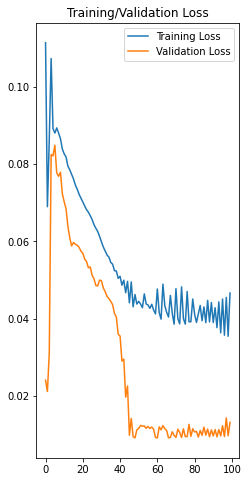

Epoch 1/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0279 - mae: 0.0237 - rmse: 0.0278 - val_loss: 0.0178 - val_mae: 0.0147 - val_rmse: 0.0167
Epoch 2/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0362 - mae: 0.0323 - rmse: 0.0360 - val_loss: 0.0296 - val_mae: 0.0279 - val_rmse: 0.0289
Epoch 3/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0397 - mae: 0.0360 - rmse: 0.0396 - val_loss: 0.0170 - val_mae: 0.0143 - val_rmse: 0.0161
Epoch 4/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0386 - mae: 0.0351 - rmse: 0.0384 - val_loss: 0.0301 - val_mae: 0.0283 - val_rmse: 0.0294
Epoch 5/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0418 - mae: 0.0379 - rmse: 0.0416 - val_loss: 0.0192 - val_mae: 0.0165 - val_rmse: 0.0183

Epoch 00005: val_loss did not improve from 0.00932
Epoch 6/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0370 - mae: 0.0329 - rmse: 0.0369 - 

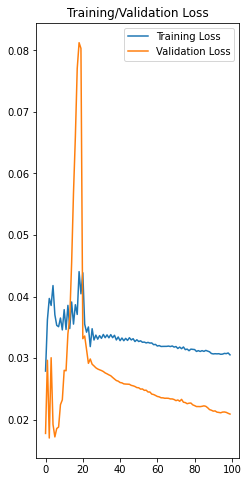

Epoch 1/100
152/152 [==============================] - 2s 5ms/step - loss: 0.0266 - mae: 0.0226 - rmse: 0.0266 - val_loss: 0.0446 - val_mae: 0.0348 - val_rmse: 0.0450
Epoch 2/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0227 - mae: 0.0183 - rmse: 0.0227 - val_loss: 0.0497 - val_mae: 0.0413 - val_rmse: 0.0500
Epoch 3/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0261 - mae: 0.0221 - rmse: 0.0261 - val_loss: 0.0434 - val_mae: 0.0336 - val_rmse: 0.0439
Epoch 4/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0215 - mae: 0.0173 - rmse: 0.0215 - val_loss: 0.0433 - val_mae: 0.0335 - val_rmse: 0.0438
Epoch 5/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0219 - mae: 0.0176 - rmse: 0.0219 - val_loss: 0.0434 - val_mae: 0.0335 - val_rmse: 0.0439

Epoch 00005: val_loss did not improve from 0.00932
Epoch 6/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0219 - mae: 0.0175 - rmse: 0.0219 - 

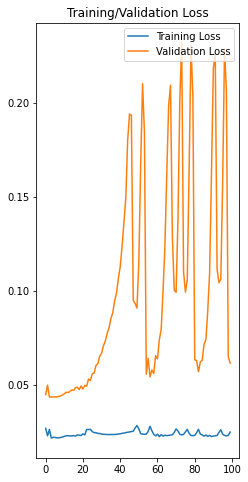

[array([[2497.2737]], dtype=float32)]
[array([[2497.2737]], dtype=float32)]
[2497.2737]


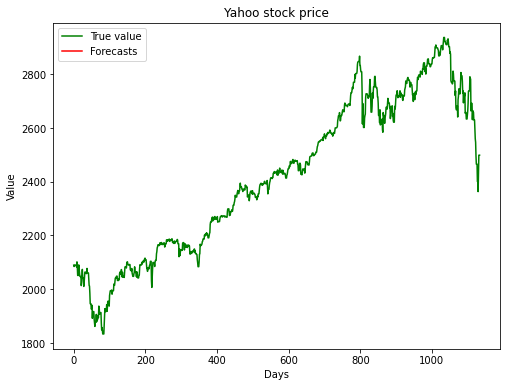

Epoch 1/60
51/51 [==============================] - 3s 15ms/step - loss: 0.1495 - mae: 0.1463 - rmse: 0.1494 - val_loss: 0.0183 - val_mae: 0.0168 - val_rmse: 0.0177
Epoch 2/60
51/51 [==============================] - 0s 7ms/step - loss: 0.0685 - mae: 0.0629 - rmse: 0.0685 - val_loss: 0.0199 - val_mae: 0.0185 - val_rmse: 0.0193
Epoch 3/60
51/51 [==============================] - 0s 7ms/step - loss: 0.1190 - mae: 0.1157 - rmse: 0.1190 - val_loss: 0.0216 - val_mae: 0.0203 - val_rmse: 0.0210
Epoch 4/60
51/51 [==============================] - 0s 7ms/step - loss: 0.1377 - mae: 0.1344 - rmse: 0.1377 - val_loss: 0.0332 - val_mae: 0.0322 - val_rmse: 0.0337
Epoch 5/60
51/51 [==============================] - 0s 6ms/step - loss: 0.1051 - mae: 0.1003 - rmse: 0.1051 - val_loss: 0.0495 - val_mae: 0.0488 - val_rmse: 0.0500

Epoch 00005: val_loss improved from inf to 0.04949, saving model to my_model_5_0.049.h5
Epoch 6/60
51/51 [==============================] - 0s 6ms/step - loss: 0.0911 - mae: 0.08

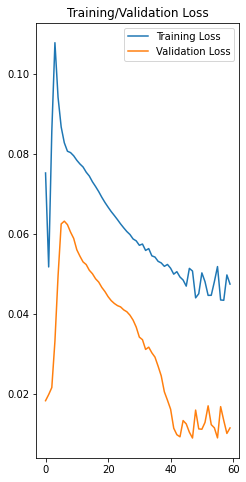

Epoch 1/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0341 - mae: 0.0306 - rmse: 0.0339 - val_loss: 0.0298 - val_mae: 0.0278 - val_rmse: 0.0292
Epoch 2/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0409 - mae: 0.0379 - rmse: 0.0408 - val_loss: 0.0227 - val_mae: 0.0206 - val_rmse: 0.0225
Epoch 3/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0547 - mae: 0.0519 - rmse: 0.0545 - val_loss: 0.0237 - val_mae: 0.0217 - val_rmse: 0.0236
Epoch 4/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0562 - mae: 0.0536 - rmse: 0.0561 - val_loss: 0.0208 - val_mae: 0.0186 - val_rmse: 0.0205
Epoch 5/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0524 - mae: 0.0495 - rmse: 0.0522 - val_loss: 0.0220 - val_mae: 0.0198 - val_rmse: 0.0217

Epoch 00005: val_loss did not improve from 0.01127
Epoch 6/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0495 - mae: 0.0466 - rmse: 0.0493 - val_lo

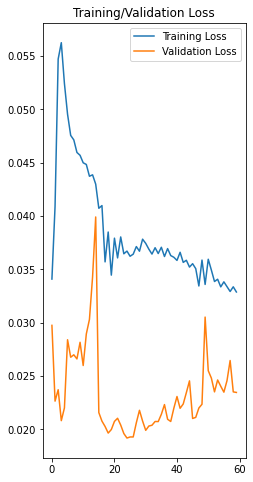

Epoch 1/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0277 - mae: 0.0240 - rmse: 0.0277 - val_loss: 0.0653 - val_mae: 0.0595 - val_rmse: 0.0654
Epoch 2/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0232 - mae: 0.0190 - rmse: 0.0232 - val_loss: 0.0554 - val_mae: 0.0490 - val_rmse: 0.0557
Epoch 3/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0224 - mae: 0.0184 - rmse: 0.0224 - val_loss: 0.0467 - val_mae: 0.0380 - val_rmse: 0.0472
Epoch 4/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0234 - mae: 0.0192 - rmse: 0.0233 - val_loss: 0.0558 - val_mae: 0.0493 - val_rmse: 0.0561
Epoch 5/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0238 - mae: 0.0197 - rmse: 0.0238 - val_loss: 0.0468 - val_mae: 0.0387 - val_rmse: 0.0472

Epoch 00005: val_loss did not improve from 0.01127
Epoch 6/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0241 - mae: 0.0199 - rmse: 0.0241 - val_lo

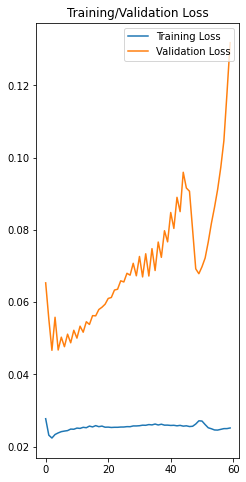

[array([[2498.1145]], dtype=float32)]
[array([[2498.1145]], dtype=float32)]
[2498.1145]


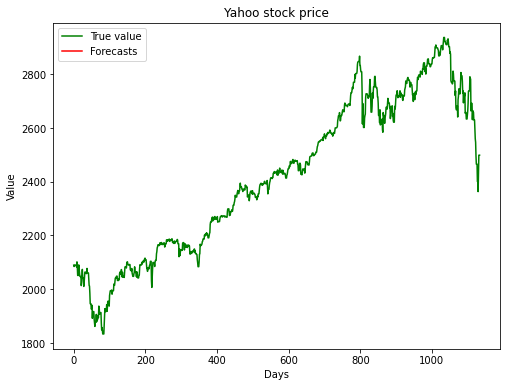

Epoch 1/90
51/51 [==============================] - 3s 16ms/step - loss: 0.1977 - mae: 0.1943 - rmse: 0.1977 - val_loss: 0.0338 - val_mae: 0.0330 - val_rmse: 0.0331
Epoch 2/90
51/51 [==============================] - 0s 6ms/step - loss: 0.0816 - mae: 0.0765 - rmse: 0.0816 - val_loss: 0.0203 - val_mae: 0.0189 - val_rmse: 0.0196
Epoch 3/90
51/51 [==============================] - 0s 7ms/step - loss: 0.1507 - mae: 0.1474 - rmse: 0.1507 - val_loss: 0.0621 - val_mae: 0.0616 - val_rmse: 0.0627
Epoch 4/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0915 - mae: 0.0868 - rmse: 0.0915 - val_loss: 0.0627 - val_mae: 0.0622 - val_rmse: 0.0633
Epoch 5/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0964 - mae: 0.0913 - rmse: 0.0964 - val_loss: 0.0714 - val_mae: 0.0710 - val_rmse: 0.0720

Epoch 00005: val_loss improved from inf to 0.07140, saving model to my_model_5_0.071.h5
Epoch 6/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0895 - mae: 0.08

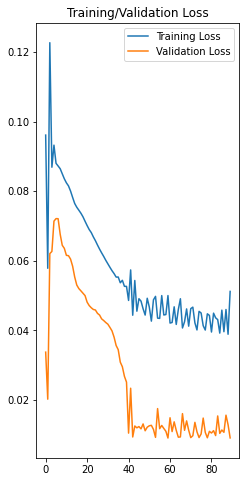

Epoch 1/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0324 - mae: 0.0284 - rmse: 0.0322 - val_loss: 0.0301 - val_mae: 0.0284 - val_rmse: 0.0292
Epoch 2/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0389 - mae: 0.0351 - rmse: 0.0387 - val_loss: 0.0227 - val_mae: 0.0205 - val_rmse: 0.0221
Epoch 3/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0372 - mae: 0.0338 - rmse: 0.0370 - val_loss: 0.0317 - val_mae: 0.0300 - val_rmse: 0.0314
Epoch 4/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0422 - mae: 0.0390 - rmse: 0.0419 - val_loss: 0.0340 - val_mae: 0.0324 - val_rmse: 0.0337
Epoch 5/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0448 - mae: 0.0415 - rmse: 0.0445 - val_loss: 0.0260 - val_mae: 0.0240 - val_rmse: 0.0254

Epoch 00005: val_loss did not improve from 0.00911
Epoch 6/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0387 - mae: 0.0349 - rmse: 0.0385 - val_lo

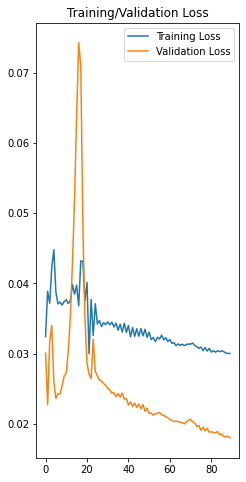

Epoch 1/90
152/152 [==============================] - 1s 7ms/step - loss: 0.0263 - mae: 0.0222 - rmse: 0.0262 - val_loss: 0.0546 - val_mae: 0.0434 - val_rmse: 0.0550
Epoch 2/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0242 - mae: 0.0199 - rmse: 0.0242 - val_loss: 0.0464 - val_mae: 0.0363 - val_rmse: 0.0466
Epoch 3/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0224 - mae: 0.0182 - rmse: 0.0224 - val_loss: 0.0454 - val_mae: 0.0349 - val_rmse: 0.0457
Epoch 4/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0217 - mae: 0.0175 - rmse: 0.0217 - val_loss: 0.0453 - val_mae: 0.0347 - val_rmse: 0.0457
Epoch 5/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0214 - mae: 0.0173 - rmse: 0.0214 - val_loss: 0.0455 - val_mae: 0.0351 - val_rmse: 0.0459

Epoch 00005: val_loss did not improve from 0.00911
Epoch 6/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0220 - mae: 0.0178 - rmse: 0.0220 - val_lo

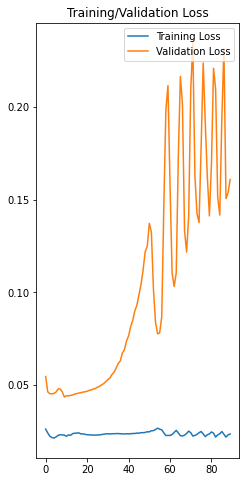

[array([[2491.8108]], dtype=float32)]
[array([[2491.8108]], dtype=float32)]
[2491.8108]


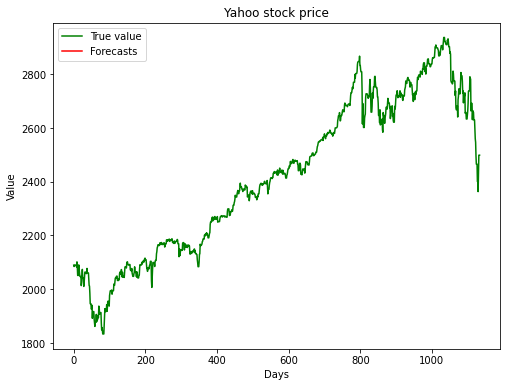

Epoch 1/120
51/51 [==============================] - 3s 17ms/step - loss: 0.1480 - mae: 0.1441 - rmse: 0.1480 - val_loss: 0.0172 - val_mae: 0.0154 - val_rmse: 0.0165
Epoch 2/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0681 - mae: 0.0618 - rmse: 0.0681 - val_loss: 0.0247 - val_mae: 0.0236 - val_rmse: 0.0240
Epoch 3/120
51/51 [==============================] - 0s 8ms/step - loss: 0.0916 - mae: 0.0870 - rmse: 0.0916 - val_loss: 0.0243 - val_mae: 0.0231 - val_rmse: 0.0236
Epoch 4/120
51/51 [==============================] - 0s 7ms/step - loss: 0.1145 - mae: 0.1105 - rmse: 0.1145 - val_loss: 0.0259 - val_mae: 0.0248 - val_rmse: 0.0253
Epoch 5/120
51/51 [==============================] - 0s 7ms/step - loss: 0.1525 - mae: 0.1497 - rmse: 0.1525 - val_loss: 0.0672 - val_mae: 0.0668 - val_rmse: 0.0678

Epoch 00005: val_loss improved from inf to 0.06724, saving model to my_model_5_0.067.h5
Epoch 6/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0947 - mae

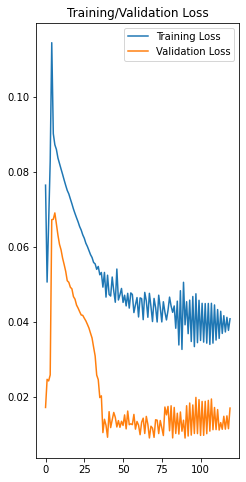

Epoch 1/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0275 - mae: 0.0233 - rmse: 0.0273 - val_loss: 0.0233 - val_mae: 0.0211 - val_rmse: 0.0226
Epoch 2/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0336 - mae: 0.0295 - rmse: 0.0334 - val_loss: 0.0383 - val_mae: 0.0372 - val_rmse: 0.0377
Epoch 3/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0366 - mae: 0.0328 - rmse: 0.0364 - val_loss: 0.0301 - val_mae: 0.0283 - val_rmse: 0.0296
Epoch 4/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0341 - mae: 0.0300 - rmse: 0.0339 - val_loss: 0.0281 - val_mae: 0.0262 - val_rmse: 0.0275
Epoch 5/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0379 - mae: 0.0342 - rmse: 0.0376 - val_loss: 0.0410 - val_mae: 0.0398 - val_rmse: 0.0409

Epoch 00005: val_loss did not improve from 0.00986
Epoch 6/120
102/102 [==============================] - 1s 6ms/step - loss: 0.0433 - mae: 0.0399 - rmse: 0.0430 - 

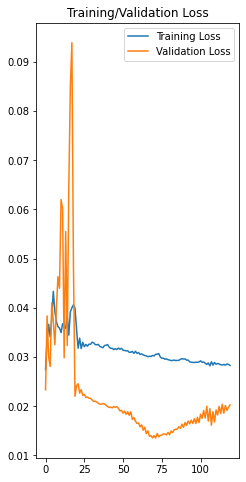

Epoch 1/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0270 - mae: 0.0229 - rmse: 0.0270 - val_loss: 0.0990 - val_mae: 0.0909 - val_rmse: 0.0987
Epoch 2/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0273 - mae: 0.0235 - rmse: 0.0273 - val_loss: 0.0563 - val_mae: 0.0466 - val_rmse: 0.0566
Epoch 3/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0242 - mae: 0.0200 - rmse: 0.0242 - val_loss: 0.0550 - val_mae: 0.0431 - val_rmse: 0.0553
Epoch 4/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0235 - mae: 0.0196 - rmse: 0.0235 - val_loss: 0.0586 - val_mae: 0.0465 - val_rmse: 0.0589
Epoch 5/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0222 - mae: 0.0183 - rmse: 0.0222 - val_loss: 0.0503 - val_mae: 0.0385 - val_rmse: 0.0509

Epoch 00005: val_loss did not improve from 0.00986
Epoch 6/120
152/152 [==============================] - 1s 6ms/step - loss: 0.0220 - mae: 0.0179 - rmse: 0.0220 - 

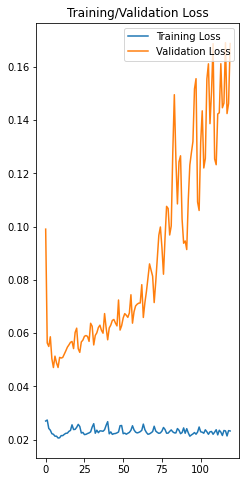

[array([[2495.5425]], dtype=float32)]
[array([[2495.5425]], dtype=float32)]
[2495.5425]


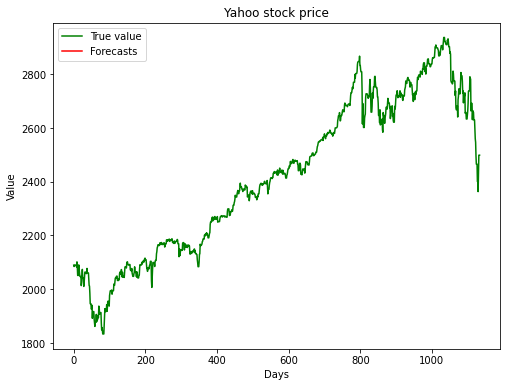

Epoch 1/50
32/32 [==============================] - 2s 24ms/step - loss: 0.2172 - mae: 0.2141 - rmse: 0.2172 - val_loss: 0.0822 - val_mae: 0.0794 - val_rmse: 0.0802
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0721 - mae: 0.0670 - rmse: 0.0721 - val_loss: 0.0349 - val_mae: 0.0335 - val_rmse: 0.0368
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0818 - mae: 0.0751 - rmse: 0.0818 - val_loss: 0.0293 - val_mae: 0.0273 - val_rmse: 0.0321
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0850 - mae: 0.0786 - rmse: 0.0849 - val_loss: 0.0249 - val_mae: 0.0221 - val_rmse: 0.0285
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0867 - mae: 0.0803 - rmse: 0.0867 - val_loss: 0.0223 - val_mae: 0.0192 - val_rmse: 0.0264

Epoch 00005: val_loss improved from inf to 0.02228, saving model to my_model_5_0.022.h5
Epoch 6/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0861 - mae: 0.

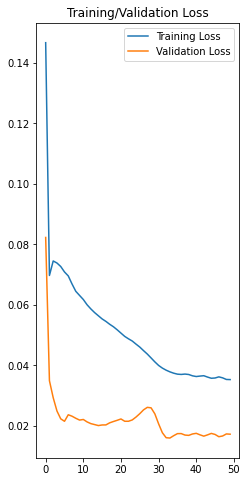

Epoch 1/50
64/64 [==============================] - 1s 16ms/step - loss: 0.0275 - mae: 0.0231 - rmse: 0.0275 - val_loss: 0.0212 - val_mae: 0.0174 - val_rmse: 0.0212
Epoch 2/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0318 - mae: 0.0279 - rmse: 0.0316 - val_loss: 0.0265 - val_mae: 0.0237 - val_rmse: 0.0265
Epoch 3/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0403 - mae: 0.0365 - rmse: 0.0401 - val_loss: 0.0155 - val_mae: 0.0119 - val_rmse: 0.0155
Epoch 4/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0530 - mae: 0.0498 - rmse: 0.0526 - val_loss: 0.0199 - val_mae: 0.0164 - val_rmse: 0.0199
Epoch 5/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0398 - mae: 0.0358 - rmse: 0.0396 - val_loss: 0.0155 - val_mae: 0.0117 - val_rmse: 0.0155

Epoch 00005: val_loss improved from 0.01671 to 0.01547, saving model to my_model_5_0.015.h5
Epoch 6/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0428 - mae: 

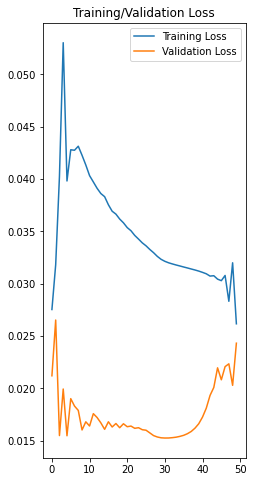

Epoch 1/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0291 - mae: 0.0246 - rmse: 0.0290 - val_loss: 0.0525 - val_mae: 0.0442 - val_rmse: 0.0539
Epoch 2/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0246 - mae: 0.0197 - rmse: 0.0246 - val_loss: 0.0466 - val_mae: 0.0359 - val_rmse: 0.0486
Epoch 3/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0267 - mae: 0.0228 - rmse: 0.0267 - val_loss: 0.0489 - val_mae: 0.0390 - val_rmse: 0.0512
Epoch 4/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0241 - mae: 0.0193 - rmse: 0.0241 - val_loss: 0.0437 - val_mae: 0.0330 - val_rmse: 0.0465
Epoch 5/50
95/95 [==============================] - 1s 7ms/step - loss: 0.0243 - mae: 0.0202 - rmse: 0.0242 - val_loss: 0.0464 - val_mae: 0.0361 - val_rmse: 0.0487

Epoch 00005: val_loss did not improve from 0.01527
Epoch 6/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0253 - mae: 0.0207 - rmse: 0.0252 - val_loss: 0.0430 -

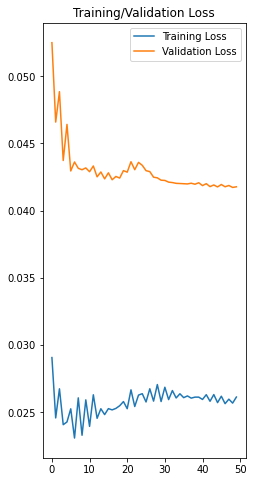

[array([[2487.3706]], dtype=float32)]
[array([[2487.3706]], dtype=float32)]
[2487.3706]


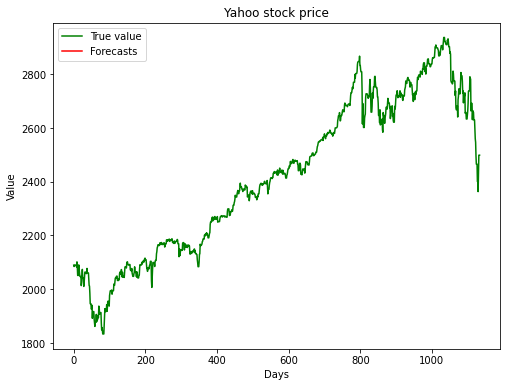

Epoch 1/90
32/32 [==============================] - 3s 25ms/step - loss: 0.2593 - mae: 0.2560 - rmse: 0.2592 - val_loss: 0.0716 - val_mae: 0.0697 - val_rmse: 0.0701
Epoch 2/90
32/32 [==============================] - 0s 9ms/step - loss: 0.0712 - mae: 0.0659 - rmse: 0.0712 - val_loss: 0.0328 - val_mae: 0.0313 - val_rmse: 0.0351
Epoch 3/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0804 - mae: 0.0736 - rmse: 0.0804 - val_loss: 0.0278 - val_mae: 0.0255 - val_rmse: 0.0309
Epoch 4/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0829 - mae: 0.0764 - rmse: 0.0829 - val_loss: 0.0229 - val_mae: 0.0200 - val_rmse: 0.0270
Epoch 5/90
32/32 [==============================] - 0s 9ms/step - loss: 0.0845 - mae: 0.0779 - rmse: 0.0845 - val_loss: 0.0207 - val_mae: 0.0178 - val_rmse: 0.0253

Epoch 00005: val_loss improved from inf to 0.02067, saving model to my_model_5_0.021.h5
Epoch 6/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0834 - mae: 0

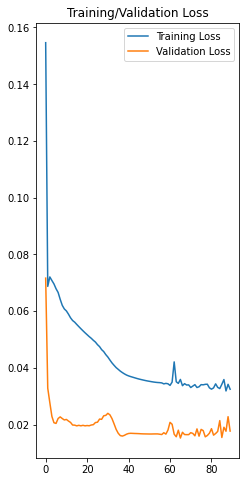

Epoch 1/90
64/64 [==============================] - 1s 16ms/step - loss: 0.0287 - mae: 0.0240 - rmse: 0.0286 - val_loss: 0.0182 - val_mae: 0.0141 - val_rmse: 0.0182
Epoch 2/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0313 - mae: 0.0269 - rmse: 0.0312 - val_loss: 0.0264 - val_mae: 0.0239 - val_rmse: 0.0264
Epoch 3/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0356 - mae: 0.0314 - rmse: 0.0355 - val_loss: 0.0335 - val_mae: 0.0317 - val_rmse: 0.0335
Epoch 4/90
64/64 [==============================] - 1s 9ms/step - loss: 0.0391 - mae: 0.0351 - rmse: 0.0388 - val_loss: 0.0339 - val_mae: 0.0321 - val_rmse: 0.0339
Epoch 5/90
64/64 [==============================] - 1s 9ms/step - loss: 0.0438 - mae: 0.0403 - rmse: 0.0435 - val_loss: 0.0289 - val_mae: 0.0266 - val_rmse: 0.0289

Epoch 00005: val_loss did not improve from 0.01594
Epoch 6/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0447 - mae: 0.0411 - rmse: 0.0444 - val_loss: 0.0248 

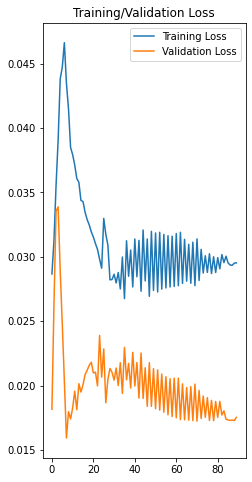

Epoch 1/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0258 - mae: 0.0214 - rmse: 0.0258 - val_loss: 0.0528 - val_mae: 0.0454 - val_rmse: 0.0535
Epoch 2/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0272 - mae: 0.0228 - rmse: 0.0271 - val_loss: 0.0421 - val_mae: 0.0331 - val_rmse: 0.0445
Epoch 3/90
95/95 [==============================] - 1s 9ms/step - loss: 0.0218 - mae: 0.0170 - rmse: 0.0218 - val_loss: 0.0455 - val_mae: 0.0347 - val_rmse: 0.0472
Epoch 4/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0238 - mae: 0.0197 - rmse: 0.0238 - val_loss: 0.0447 - val_mae: 0.0351 - val_rmse: 0.0478
Epoch 5/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0219 - mae: 0.0169 - rmse: 0.0218 - val_loss: 0.0482 - val_mae: 0.0383 - val_rmse: 0.0496

Epoch 00005: val_loss did not improve from 0.01594
Epoch 6/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0258 - mae: 0.0218 - rmse: 0.0258 - val_loss: 0.0484 -

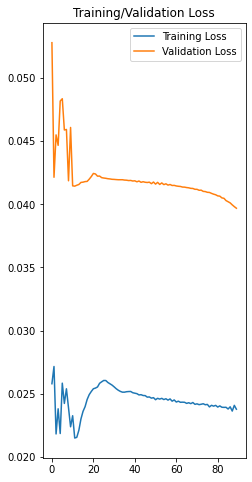

[array([[2488.634]], dtype=float32)]
[array([[2488.634]], dtype=float32)]
[2488.634]


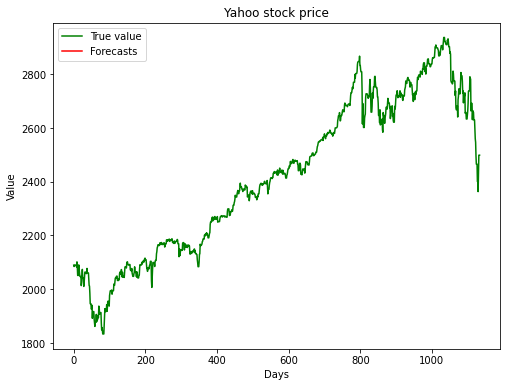

Epoch 1/120
32/32 [==============================] - 3s 25ms/step - loss: 0.2074 - mae: 0.2043 - rmse: 0.2074 - val_loss: 0.0906 - val_mae: 0.0876 - val_rmse: 0.0883
Epoch 2/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0722 - mae: 0.0670 - rmse: 0.0722 - val_loss: 0.0353 - val_mae: 0.0340 - val_rmse: 0.0371
Epoch 3/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0814 - mae: 0.0747 - rmse: 0.0814 - val_loss: 0.0283 - val_mae: 0.0262 - val_rmse: 0.0313
Epoch 4/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0845 - mae: 0.0780 - rmse: 0.0845 - val_loss: 0.0241 - val_mae: 0.0212 - val_rmse: 0.0279
Epoch 5/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0858 - mae: 0.0792 - rmse: 0.0857 - val_loss: 0.0230 - val_mae: 0.0200 - val_rmse: 0.0270

Epoch 00005: val_loss improved from inf to 0.02301, saving model to my_model_5_0.023.h5
Epoch 6/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0840 - mae

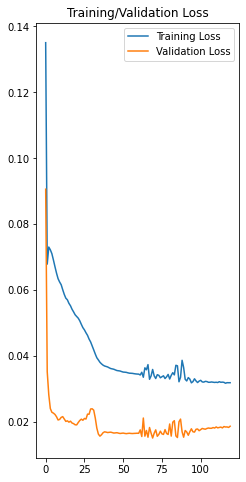

Epoch 1/120
64/64 [==============================] - 1s 16ms/step - loss: 0.0255 - mae: 0.0205 - rmse: 0.0255 - val_loss: 0.0172 - val_mae: 0.0133 - val_rmse: 0.0172
Epoch 2/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0276 - mae: 0.0225 - rmse: 0.0276 - val_loss: 0.0157 - val_mae: 0.0117 - val_rmse: 0.0157
Epoch 3/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0277 - mae: 0.0230 - rmse: 0.0278 - val_loss: 0.0176 - val_mae: 0.0135 - val_rmse: 0.0176
Epoch 4/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0296 - mae: 0.0251 - rmse: 0.0296 - val_loss: 0.0219 - val_mae: 0.0187 - val_rmse: 0.0219
Epoch 5/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0320 - mae: 0.0276 - rmse: 0.0320 - val_loss: 0.0224 - val_mae: 0.0194 - val_rmse: 0.0224

Epoch 00005: val_loss did not improve from 0.01520
Epoch 6/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0339 - mae: 0.0295 - rmse: 0.0338 - val_loss: 0

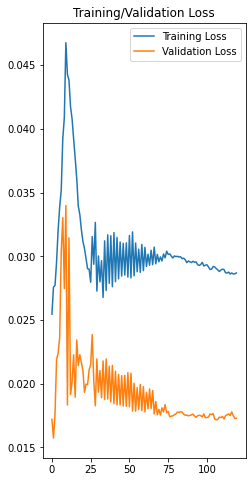

Epoch 1/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0247 - mae: 0.0201 - rmse: 0.0246 - val_loss: 0.0433 - val_mae: 0.0324 - val_rmse: 0.0454
Epoch 2/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0251 - mae: 0.0206 - rmse: 0.0251 - val_loss: 0.0541 - val_mae: 0.0460 - val_rmse: 0.0550
Epoch 3/120
95/95 [==============================] - 1s 9ms/step - loss: 0.0243 - mae: 0.0199 - rmse: 0.0242 - val_loss: 0.0429 - val_mae: 0.0338 - val_rmse: 0.0450
Epoch 4/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0242 - mae: 0.0196 - rmse: 0.0242 - val_loss: 0.0494 - val_mae: 0.0399 - val_rmse: 0.0508
Epoch 5/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0244 - mae: 0.0201 - rmse: 0.0244 - val_loss: 0.0416 - val_mae: 0.0309 - val_rmse: 0.0442

Epoch 00005: val_loss did not improve from 0.01520
Epoch 6/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0233 - mae: 0.0187 - rmse: 0.0233 - val_loss: 0.

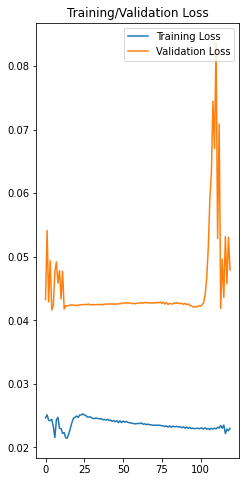

[array([[2493.9172]], dtype=float32)]
[array([[2493.9172]], dtype=float32)]
[2493.9172]


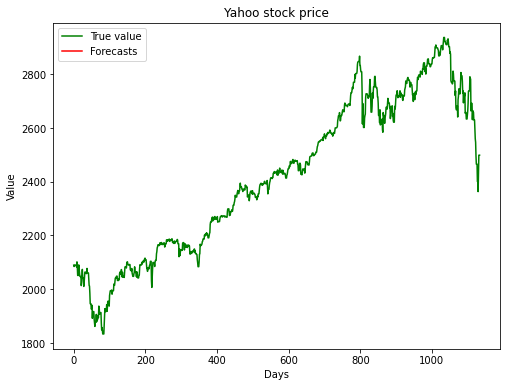

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  path_to_save=r'modelo_aux_close_'+str(t)+'.h5'
  model.save(path_to_save)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.06434341383477053, 0.06119521657625834, 0.06425503740708033, 0.04697951140503089, 0.042534912998477614, 0.04726192026088635] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.04444823918243249, 0.04059875848392645, 0.04442042298614979, 0.04589739859104156, 0.04307132219895721, 0.04598029721528293] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.037240641824901104, 0.032922704791029295, 0.037201218828558924, 0.051645577844853206, 0.04806711724648873, 0.05171712293600043] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.041800163675927454, 0.038022465962502694, 0.041718120614273685, 0.04177285210332937, 0.038668130612414746, 0.04184581202247905] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.03812603251663623, 0.03402859172611325, 0.03802262454949044, 0.05234075907824768, 0.04875847

In [20]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.064343,0.061195,0.064255,0.046980,0.042535,0.047262
2,0.044448,0.040599,0.044420,0.045897,0.043071,0.045980
3,0.037241,0.032923,0.037201,0.051646,0.048067,0.051717
4,0.041800,0.038022,0.041718,0.041773,0.038668,0.041846
5,0.038126,0.034029,0.038023,0.052341,0.048758,0.052357
6,0.035334,0.031075,0.035227,0.044430,0.040729,0.044433
7,0.037066,0.032445,0.036927,0.027455,0.021550,0.029602
8,0.033156,0.028301,0.033030,0.027157,0.021093,0.029374
9,0.031723,0.026799,0.031606,0.027765,0.021680,0.029903


In [21]:
final_df.to_csv(r"resultados_close.csv",index=True)